### Employee Attrition and Performance Analysis

#### importing the required packages

In [240]:
import pandas as pd
import numpy as np
import pandas
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter

from sklearn import preprocessing
from sklearn.utils import resample
from imblearn import over_sampling as os
from imblearn.over_sampling import SMOTE
from imblearn import pipeline as pl
from imblearn.metrics import (geometric_mean_score,make_index_balanced_accuracy)
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from xgboost.sklearn import XGBClassifier 
from sklearn import model_selection
from sklearn.model_selection import cross_val_score



from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#### read in the excel data

In [139]:
hr_data = pd.read_excel('data/HR-Employee-Attrition.xlsx')

In [140]:
print(hr_data.shape)
print(hr_data.columns)

(1470, 35)
Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')


In [141]:
hr_data.head(4)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0


In [142]:
pandas.set_option('display.max_columns',None) # set the option to display all the columns of a dataframe....

In [143]:
cols_to_remove = ['EmployeeCount','Over18','StandardHours','EmployeeNumber','JobLevel'] ### remove the unnecessary columns
hr_data = hr_data.drop(hr_data[cols_to_remove],axis=1)
len(hr_data.columns)

30

In [144]:
hr_data.dtypes

Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StockOptionLevel             int64
TotalWorkingYears            int64
TrainingTimesLastYear        int64
WorkLifeBalance              int64
YearsAtCompany               int64
YearsInCurrentRole           int64
YearsSinceLastPromot

In [145]:
# creating a list of categorical variables
cat_var = ['BusinessTravel','Department','Education','EducationField','EnvironmentSatisfaction','JobInvolvement','Gender','JobRole','JobSatisfaction',
'MaritalStatus','OverTime','PerformanceRating','RelationshipSatisfaction','WorkLifeBalance','StockOptionLevel']

In [146]:
len(cat_var)

15

In [147]:
# converting the object data type to category dtype
for var in cat_var:
    hr_data[var] = hr_data[var].astype('category')

In [148]:
len(hr_data.select_dtypes(include=['category']).columns)

15

In [149]:
### creating a new dataframe with all categorical descriptions
hr_desc = hr_data.copy()

In [150]:
#### mapping all data with those description so as to analyze
Education_desc = {1 : 'Below College', 2 : 'College' , 3 : 'Bachelor' , 4 : 'Master' , 5 : 'Doctor'}
EnvironmentSatisfaction_desc = {1 : 'Low' , 2 : 'Medium' , 3 : 'High' , 4 : 'Very High'}
JobInvolvement_desc  = {1 : 'Low' , 2 : 'Medium' , 3 : 'High' ,4 : 'Very High'}
JobSatisfaction_desc = {1 : 'Low' , 2 : 'Medium' , 3 : 'High' ,4 : 'Very High'}
PerformanceRating_desc = {1 :'Low' , 2 : 'Good' , 3 : 'Excellent' , 4 : 'Outstanding'}
RelationshipSatisfaction_desc  = {1 : 'Low' , 2 : 'Medium' , 3 : 'High' ,4 : 'Very High'}
WorkLifeBalance_desc = {1 : 'Bad' , 2 : 'Good' , 3 : 'Better' ,4 : 'Best'}


In [151]:
hr_desc['Education'].replace(Education_desc,inplace=True)
hr_desc['EnvironmentSatisfaction'] = hr_desc['EnvironmentSatisfaction'].map(EnvironmentSatisfaction_desc)
hr_desc['JobInvolvement'] = hr_desc['JobInvolvement'].map(JobInvolvement_desc)
hr_desc['JobSatisfaction'] = hr_desc['JobSatisfaction'].map(JobSatisfaction_desc)
hr_desc['PerformanceRating'] = hr_desc['PerformanceRating'].map(PerformanceRating_desc)
hr_desc['RelationshipSatisfaction'] = hr_desc['RelationshipSatisfaction'].map(RelationshipSatisfaction_desc)
hr_desc['WorkLifeBalance'] = hr_desc['WorkLifeBalance'].map(WorkLifeBalance_desc)

In [152]:
obj_cols =hr_desc.select_dtypes(include=['object'])

In [153]:
len(obj_cols.columns)

8

In [154]:
for var in obj_cols:
    hr_desc[var] = hr_desc[var].astype('category') ### there are 17 categorical columns and 14 int columns

In [155]:
hr_desc.head(3)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,College,Life Sciences,Medium,Female,94,High,Sales Executive,Very High,Single,5993,19479,8,Yes,11,Excellent,Low,0,8,0,Bad,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,Below College,Life Sciences,High,Male,61,Medium,Research Scientist,Medium,Married,5130,24907,1,No,23,Outstanding,Very High,1,10,3,Better,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,College,Other,Very High,Male,92,Medium,Laboratory Technician,High,Single,2090,2396,6,Yes,15,Excellent,Medium,0,7,3,Better,0,0,0,0


### data exploration and analysis

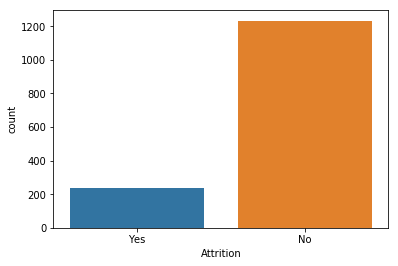

No     1233
Yes     237
Name: Attrition, dtype: int64

In [156]:
sns.countplot(x='Attrition',data=hr_data);  ####  the employee attrition is 
plt.show()
hr_desc.Attrition.value_counts()

#### there is 17% attrition rate in the dataset  - 237 out of 1470 totally

### would like to see what factors make these employee resign their jobs

In [157]:
hr_desc.groupby('Attrition').mean()


,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Attrition,,,,,,,,,,,,,,
No,37.561233,812.504461,8.915653,65.952149,6832.739659,14265.779400,2.645580,15.231144,11.862936,2.832928,7.369019,4.484185,2.234388,4.367397
Yes,33.607595,750.362869,10.632911,65.573840,4787.092827,14559.308017,2.940928,15.097046,8.244726,2.624473,5.130802,2.902954,1.945148,2.852321


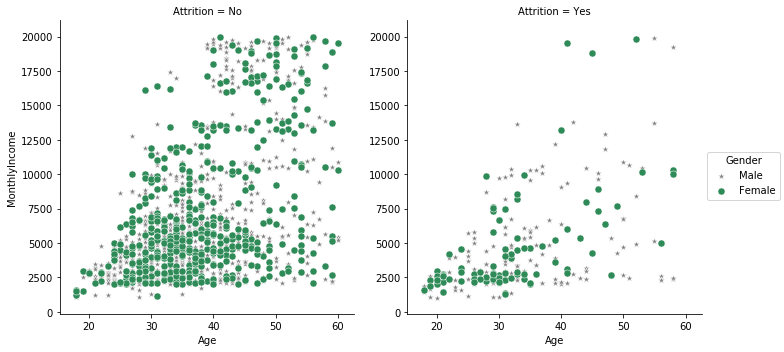

In [158]:
'''_ = sns.FacetGrid(hr_desc['Attrition'], hr_desc['Age'],hue=hr_desc.Gender);
plt.title("Age Vs Attrition ")
#sns.despine()
plt.show()'''

kws = dict(s=50, linewidth=.5, edgecolor="w")
pal = dict(Male="gray", Female="Seagreen")
g = sns.FacetGrid(hr_desc, col="Attrition",  hue="Gender",size=5,palette=pal,
                  hue_order=['Male','Female'],hue_kws=dict(marker=["*", "o"]))
g = (g.map(plt.scatter, "Age","MonthlyIncome",**kws).add_legend());
plt.show()


###  the average age of customers who changed jobs are less than those who didn't

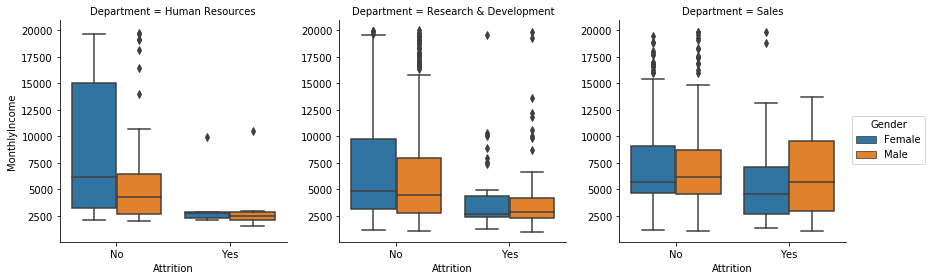

In [159]:
sns.factorplot(data=hr_desc,x='Attrition',y='MonthlyIncome',hue='Gender',col='Department',kind='box');
plt.show()

#### male attrition is more in sales department than the females.

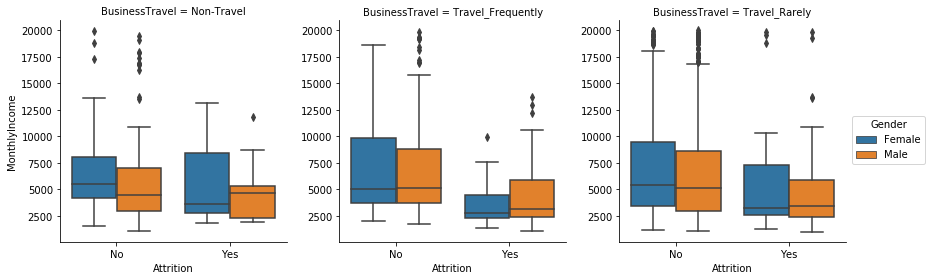

In [160]:
sns.factorplot(data=hr_desc , x= 'Attrition', y= 'MonthlyIncome' ,hue= 'Gender',col= 'BusinessTravel', kind='box');
plt.show()

### attrition seems to be more among female when there are no travel...

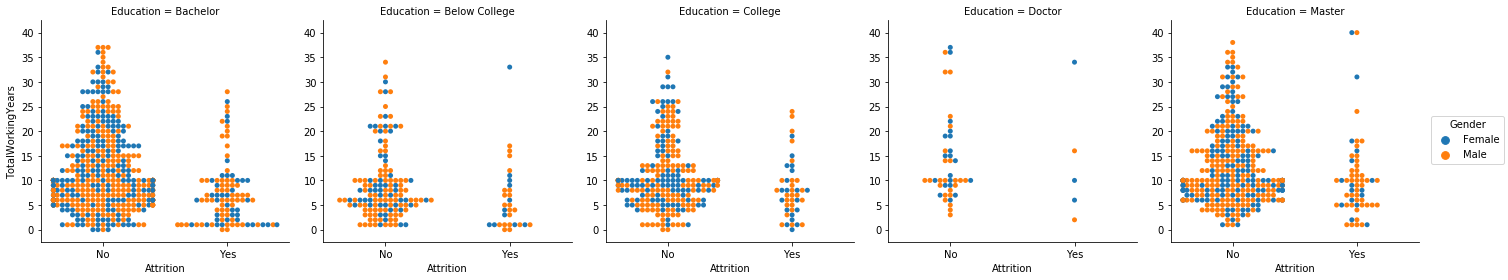

In [161]:
sns.factorplot(data=hr_desc,x='Attrition',y='TotalWorkingYears', hue ='Gender',col = 'Education',kind='swarm');

### attrition seems to be more among female who have bachelor's degree and increase with more years of experience

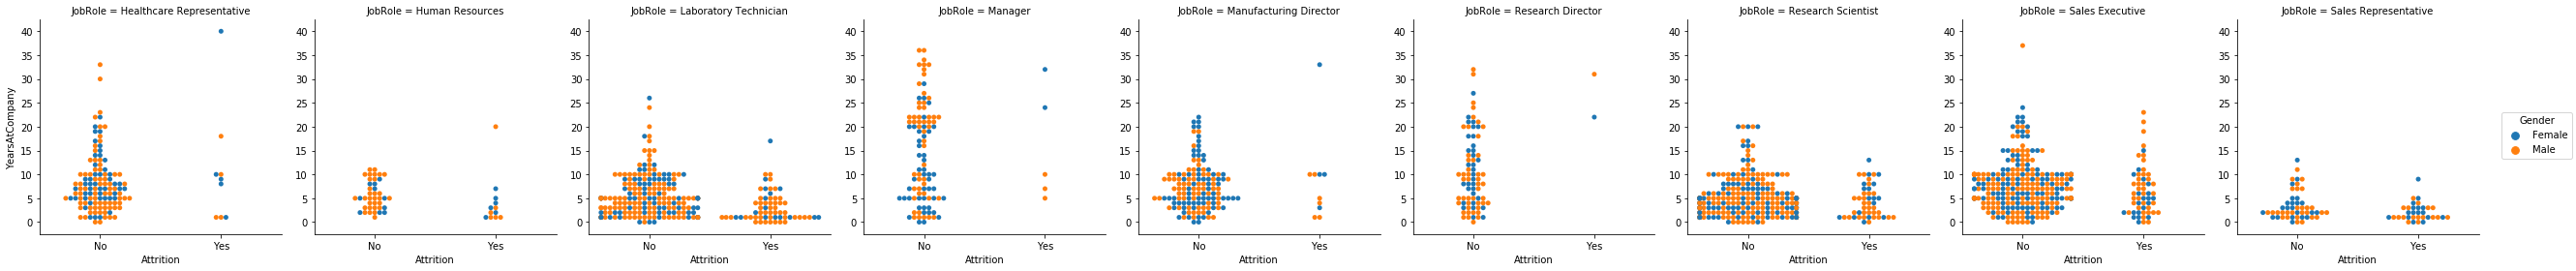

In [162]:
sns.factorplot(data=hr_desc,x='Attrition',y='YearsAtCompany', hue ='Gender',col = 'JobRole',kind='swarm');

### there are more male employees who resign as being an Lab Technician and Research Scientists

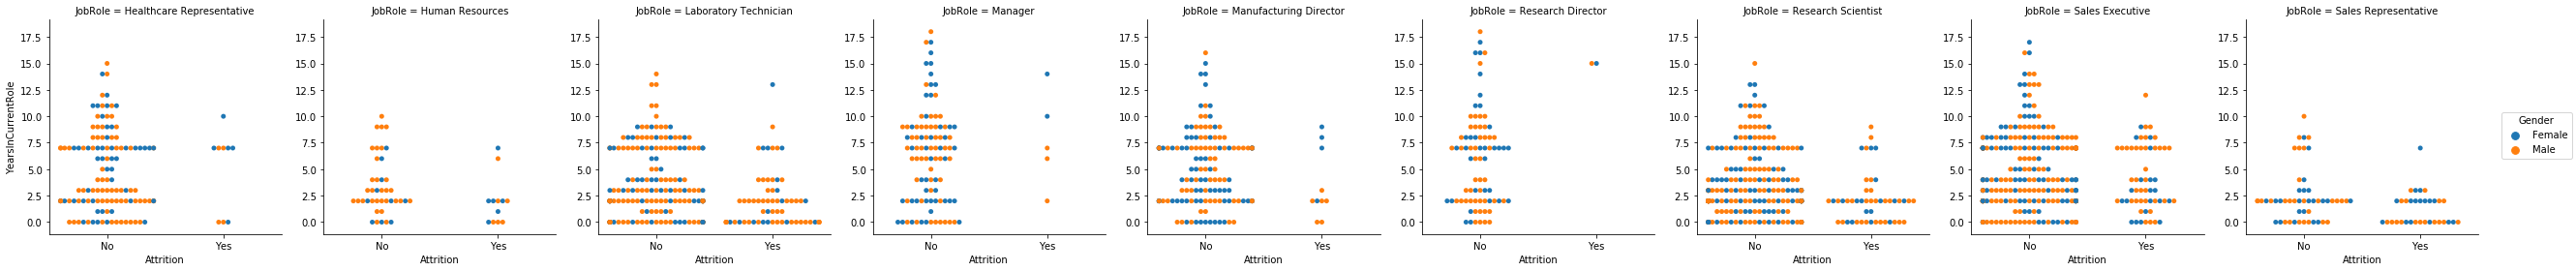

In [163]:
sns.factorplot(data=hr_desc,x='Attrition',y='YearsInCurrentRole', hue ='Gender',col = 'JobRole',kind='swarm');

In [164]:
### create a new column YearWithoutchange to get the how many years the person in this job role  
hr_desc['YearWithoutChange'] =  hr_desc['YearsInCurrentRole'] - hr_desc['YearsSinceLastPromotion']

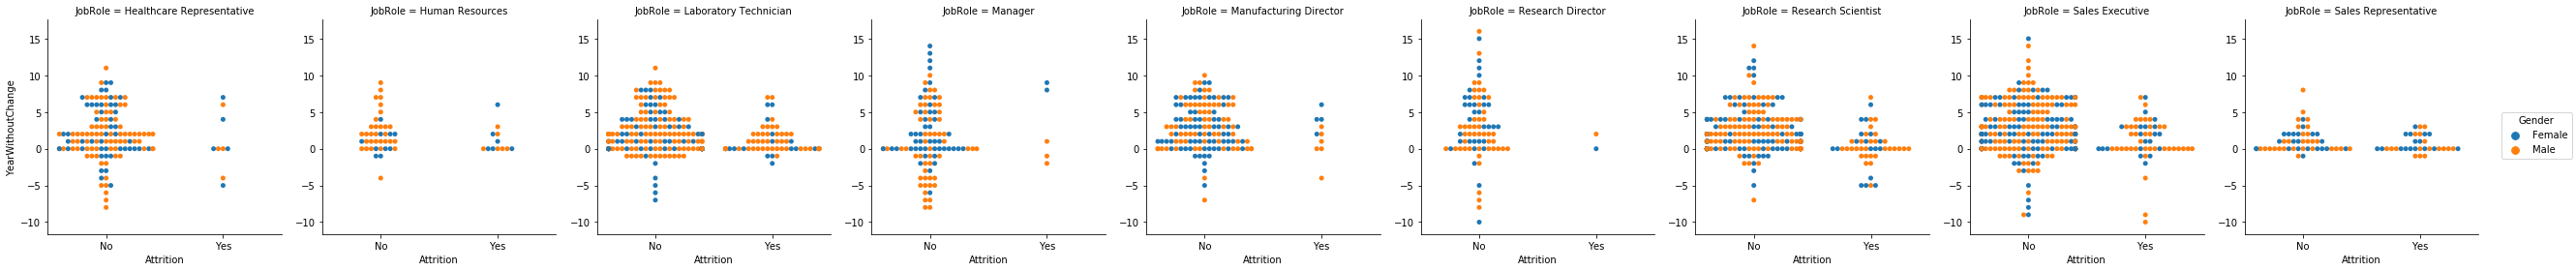

In [165]:
sns.factorplot(data=hr_desc,x='Attrition',y='YearWithoutChange', hue ='Gender',col = 'JobRole',kind='swarm');

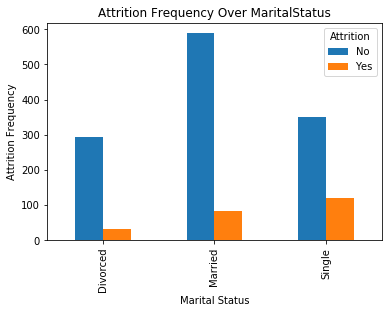

In [166]:
pd.crosstab(hr_desc.MaritalStatus,hr_desc.Attrition).plot(kind='bar');
plt.title("Attrition Frequency Over MaritalStatus");
plt.xlabel('Marital Status');
plt.ylabel('Attrition Frequency');

### single people tend to change jobs frequently

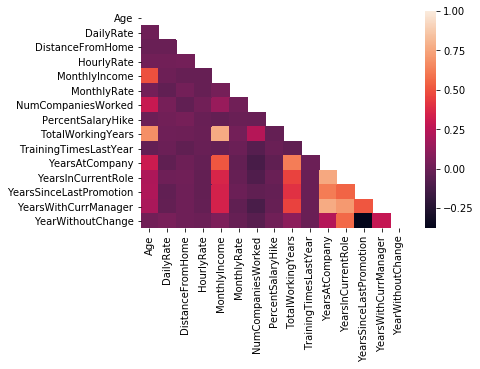

In [167]:
### see the correlation among features using correlation matrix
corr = hr_desc.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,mask = mask,
           xticklabels = corr.columns.values,
           yticklabels = corr.columns.values);

#### Total working yrs,Number of years working in a company, in current role,years since last promotion
####  and monthly income seems to have high correlations

In [168]:
hr_desc.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'YearWithoutChange'],
      dtype='object')

In [169]:
hr_data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2


In [170]:
del_col = ['DailyRate','MonthlyRate','HourlyRate'] # deleting dailyrate,monthly rate and hourly rate columns 
hr_desc = hr_desc.drop(hr_desc[del_col],axis=1) 

###  Pandas has a function which can turn a categorical variable into a series of zeros and ones, which makes
### them a lot easier to quantify and compare.(get_dummies)

In [171]:
# creating dummies for cat columns   -- one hot encoding  
for var in cat_var:
    cat_list = 'var' + '_' +var
    cat_list = pd.get_dummies(hr_desc[var],prefix=var)
    hr1 =hr_desc.join(cat_list)
    hr_desc = hr1

In [220]:
hr_desc.head(4)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,YearWithoutChange,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,Education_Bachelor,Education_Below College,Education_College,Education_Doctor,Education_Master,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,EnvironmentSatisfaction_High,EnvironmentSatisfaction_Low,EnvironmentSatisfaction_Medium,EnvironmentSatisfaction_Very High,JobInvolvement_High,JobInvolvement_Low,JobInvolvement_Medium,JobInvolvement_Very High,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,JobSatisfaction_High,JobSatisfaction_Low,JobSatisfaction_Medium,JobSatisfaction_Very High,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,PerformanceRating_Excellent,PerformanceRating_Outstanding,RelationshipSatisfaction_High,RelationshipSatisfaction_Low,RelationshipSatisfaction_Medium,RelationshipSatisfaction_Very High,WorkLifeBalance_Bad,WorkLifeBalance_Best,WorkLifeBalance_Better,WorkLifeBalance_Good,StockOptionLevel_0,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3
0,41,Yes,Travel_Rarely,Sales,1,College,Life Sciences,Medium,Female,High,Sales Executive,Very High,Single,5993,8,Yes,11,Excellent,Low,0,8,0,Bad,6,4,0,5,4,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0
1,49,No,Travel_Frequently,Research & Development,8,Below College,Life Sciences,High,Male,Medium,Research Scientist,Medium,Married,5130,1,No,23,Outstanding,Very High,1,10,3,Better,10,7,1,7,6,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0
2,37,Yes,Travel_Rarely,Research & Development,2,College,Other,Very High,Male,Medium,Laboratory Technician,High,Single,2090,6,Yes,15,Excellent,Medium,0,7,3,Better,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0
3,33,No,Travel_Frequently,Research & Development,3,Master,Life Sciences,Very High,Female,High,Research Scientist,High,Married,2909,1,Yes,11,Excellent,High,0,8,3,Better,8,7,3,0,4,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0


In [173]:
# creating a list of variables
hr_vars=hr_desc.columns.values.tolist()
to_keep=[i for i in hr_vars if i not in cat_var]
print(len(hr_vars))
print(len(to_keep))
hr_final = hr_desc[to_keep] ## 18 columns dropped as dummies were created for them..
hr_final_vars = hr_final.columns.values.tolist() # creating a list of final variables


87
72


In [174]:
y = ['Attrition']
X = [i for i in hr_final_vars if i not in y] # excluding the target variable Attrition 

### normalizing the data before feature selection

In [175]:
### using preprocessing package and Mix Max scaler method

In [176]:
#y = hr_data.Attrition

In [177]:
x = hr_final[X].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_hr = pandas.DataFrame(x_scaled)

C:\Users\Suhasini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [234]:
hr_final.loc[:, X.columns].values

array([[  41,    1, 5993, ...,    1,    0,    0],
       [  49,    8, 5130, ...,    0,    1,    0],
       [  37,    2, 2090, ...,    1,    0,    0],
       ..., 
       [  27,    4, 6142, ...,    0,    1,    0],
       [  49,    2, 5390, ...,    1,    0,    0],
       [  34,    8, 4404, ...,    1,    0,    0]], dtype=int64)

In [178]:
len(df_hr.columns) ## total 71 features excluding the target variable 

71

In [225]:
df_hr.head()

,Age,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,YearWithoutChange,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,Education_Bachelor,Education_Below College,Education_College,Education_Doctor,Education_Master,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,EnvironmentSatisfaction_High,EnvironmentSatisfaction_Low,EnvironmentSatisfaction_Medium,EnvironmentSatisfaction_Very High,JobInvolvement_High,JobInvolvement_Low,JobInvolvement_Medium,JobInvolvement_Very High,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,JobSatisfaction_High,JobSatisfaction_Low,JobSatisfaction_Medium,JobSatisfaction_Very High,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,PerformanceRating_Excellent,PerformanceRating_Outstanding,RelationshipSatisfaction_High,RelationshipSatisfaction_Low,RelationshipSatisfaction_Medium,RelationshipSatisfaction_Very High,WorkLifeBalance_Bad,WorkLifeBalance_Best,WorkLifeBalance_Better,WorkLifeBalance_Good,StockOptionLevel_0,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3
0,0.547619,0.000000,0.262454,0.888889,0.000000,0.200,0.0,0.15,0.222222,0.000000,0.294118,0.538462,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.738095,0.250000,0.217009,0.111111,0.857143,0.250,0.5,0.25,0.388889,0.066667,0.411765,0.615385,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.452381,0.035714,0.056925,0.666667,0.285714,0.175,0.5,0.00,0.000000,0.000000,0.000000,0.384615,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.357143,0.071429,0.100053,0.111111,0.000000,0.200,0.5,0.20,0.388889,0.200000,0.000000,0.538462,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.214286,0.035714,0.129489,1.000000,0.071429,0.150,0.5,0.05,0.111111,0.133333,0.117647,0.384615,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [179]:
df_hr.columns = hr_final[X].columns #assigning the column names for the final dataframe

In [180]:
hr_final.Attrition = hr_final.Attrition.cat.codes

C:\Users\Suhasini\Anaconda3\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


### Feature Selection
### Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and
### choose either the best or worst performing feature, setting the feature aside and then repeating
### the process with the rest of the features. This process is applied until all features in the dataset are exhausted.
### The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [181]:
logreg = LogisticRegression() ### instantiating a log reg classifier
rfe = RFE(logreg)     
rfe = rfe.fit(df_hr[X] , hr_final[y])
print(rfe.support_) ### the features selected by RFE
print(rfe.ranking_) ### ranking for various features

C:\Users\Suhasini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ True  True  True  True False  True  True  True  True  True  True  True
  True  True False False  True False False False False False False False
  True False  True  True  True False  True False False False  True False
  True False False  True False  True False False  True False False  True
 False  True False  True False False False  True  True False False False
  True False False  True False  True False  True  True  True False]
[ 1  1  1  1 16  1  1  1  1  1  1  1  1  1 35 36  1 13 17 23 29  2 28 10  1
 11  1  1  1 14  1 15 12  4  1 30  1  3 19  1  7  1  8  9  1 24 33  1 37  1
 32  1 18 31  6  1  1 34 27 22  1 21 20  1 25  1 26  1  1  1  5]


In [ ]:
rfe.feature

In [182]:
### find the columns which has high ranking.... 
cols = df_hr.loc[:,rfe.support_].columns.tolist()
X = df_hr[cols]   ### selected features of the model
y = hr_final['Attrition']  ### target variable

In [189]:
cols

['Age',
 'DistanceFromHome',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'YearWithoutChange',
 'BusinessTravel_Non-Travel',
 'BusinessTravel_Travel_Frequently',
 'Department_Research & Development',
 'EducationField_Life Sciences',
 'EducationField_Medical',
 'EducationField_Other',
 'EducationField_Technical Degree',
 'EnvironmentSatisfaction_Low',
 'JobInvolvement_Low',
 'JobInvolvement_Very High',
 'JobRole_Healthcare Representative',
 'JobRole_Laboratory Technician',
 'JobRole_Research Director',
 'JobRole_Sales Representative',
 'JobSatisfaction_Low',
 'JobSatisfaction_Very High',
 'OverTime_No',
 'OverTime_Yes',
 'RelationshipSatisfaction_Low',
 'WorkLifeBalance_Bad',
 'WorkLifeBalance_Better',
 'StockOptionLevel_0',
 'StockOptionLevel_1',
 'StockOptionLevel_2']

In [183]:
### upsampling using SMOTE- synthetic minority over sampling technique

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size = .3,random_state=12)

In [185]:
print('Original dataset shape {}'.format(Counter(y)))

Original dataset shape Counter({0: 1233, 1: 237})


In [186]:
sm = SMOTE(ratio='minority',random_state=123) ### using smote on minority class
X_res, y_res = sm.fit_sample(X_train, y_train)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({0: 863, 1: 863})


In [245]:
X_res

array([[ 0.16666667,  0.96428571,  0.40179042, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.45238095,  0.32142857,  0.19331227, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.64285714,  1.        ,  0.12864666, ...,  1.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.288678  ,  0.32587414,  0.25735144, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.42026027,  0.57395746,  0.36249592, ...,  0.55817811,
         0.        ,  0.        ],
       [ 0.27219446,  0.0637113 ,  0.09264776, ...,  1.        ,
         0.        ,  0.        ]])

In [187]:
X_train = X_res 
y_train = y_res

In [194]:
type(y_train)

numpy.ndarray

In [206]:
X_train.shape

(1726, 35)

In [219]:
X_test.columns


Index(['Age', 'DistanceFromHome', 'MonthlyIncome', 'NumCompaniesWorked',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'YearWithoutChange', 'BusinessTravel_Non-Travel',
       'BusinessTravel_Travel_Frequently', 'Department_Research & Development',
       'EducationField_Life Sciences', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'EnvironmentSatisfaction_Low', 'JobInvolvement_Low',
       'JobInvolvement_Very High', 'JobRole_Healthcare Representative',
       'JobRole_Laboratory Technician', 'JobRole_Research Director',
       'JobRole_Sales Representative', 'JobSatisfaction_Low',
       'JobSatisfaction_Very High', 'OverTime_No', 'OverTime_Yes',
       'RelationshipSatisfaction_Low', 'WorkLifeBalance_Bad',
       'WorkLifeBalance_Better', 'StockOptionLevel_0', 'StockOptionLevel_1',
       'StockOptionLevel_2'],
      dty

In [241]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=1, random_state=0).fit(X_train, y_train)
gbc_model = gbc.fit(X_train,y_train) # fit the model on train data
y_pred = gbc.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(gbc.score(X_test, y_test))
cross_val_score(gbc, X_train,y_train)
print(classification_report(y_test,y_pred))

0.859410430839
0.859410430839
             precision    recall  f1-score   support

          0       0.91      0.92      0.92       370
          1       0.57      0.52      0.54        71

avg / total       0.85      0.86      0.86       441



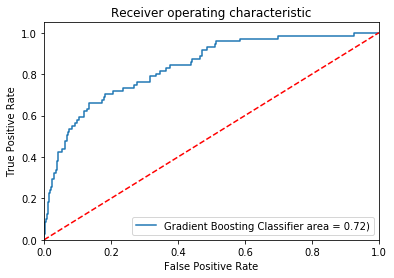

In [242]:
gbc_roc_auc = roc_auc_score(y_test, gbc.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, gbc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Gradient Boosting Classifier area = %0.2f)' % gbc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('xgb_ROC')
plt.show()

In [244]:
type(y_train)

numpy.ndarray

In [133]:
# function to evaluate cross validation score for various models
def cross_val_fn(model):
    kFold = model_selection.KFold(n_splits=10,random_state=10)
    scoring = 'accuracy'
    cross_val_results = cross_val_score(model,X_train,y_train,cv =kFold,scoring=scoring)
    return cross_val_results

###### adding widgets 

In [252]:
from ipywidgets import interact,interactive,fixed,interact_manual
import ipywidgets as widgets
from IPython.display import display

from ipywidgets import HBox, VBox , Label, Output

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

The Model selected :  Random Forest
---------------------------------------------------
Accuracy of Random Forest classifier on test set : 0.86
Evaluate random forest model : 0.857142857143
Cross Validation Score - 10 Fold    :  0.93
             precision    recall  f1-score   support

          0       0.89      0.95      0.92       370
          1       0.59      0.37      0.45        71

avg / total       0.84      0.86      0.84       441



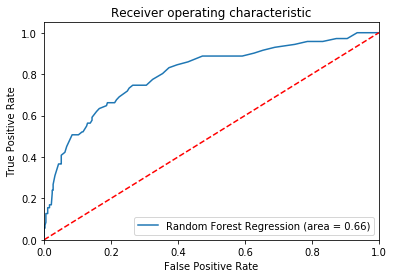

In [253]:
model_label = widgets.Label("Select the model : ")
display(model_label)
model_selection_in = widgets.Dropdown(options=['Logistic Regression','Random Forest','Support Vector Machine','Gradient Boosting Classifier'])
display(model_selection_in)

show_update = widgets.Button(description='Show',tooltip = 'click me')
display(show_update)

def model_select(b):
    print("The Model selected : ", model_selection_in.value)
    if (model_selection_in.value == 'Random Forest') :
        model_rf()
    if (model_selection_in.value == 'Logistic Regression') :
        model_lg()
    if (model_selection_in.value == 'Support Vector Machine') :
        model_svm()
    if (model_selection_in.value == 'Gradient Boosting Classifier') :
        model_gbc()
        
show_update.on_click(model_select)

In [103]:
  
def model_rf():
    rf = RandomForestClassifier(n_estimators=100)
    rf_model = rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    
    accuracy = round(rf.score(X_test,y_test),2)
    accu_score = accuracy_score(y_test,y_pred)
    class_report = classification_report(y_test,y_pred)
    
    print("---------------------------------------------------")
    print('Accuracy of Random Forest classifier on test set : {:.2f}'.format(rf.score(X_test,y_test)))
    print("Evaluate random forest model :" ,accuracy_score(y_test,y_pred))
    print("Cross Validation Score - 10 Fold    : " , round((cross_val_fn(rf).mean()),2) )
    print(classification_report(y_test,y_pred))
    
        
    rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Random Forest Regression (area = %0.2f)' % rf_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    #plt.savefig('RF_ROC')
    plt.show()
    return accuracy,accu_score,class_report
    

In [101]:
def model_lg():
    logreg = LogisticRegression()
    lg_model = logreg.fit(X_train,y_train)
    y_pred = logreg.predict(X_test)
    
    accuracy = round(logreg.score(X_test,y_test),2)
    accu_score = round(accuracy_score(y_test,y_pred),2)
    class_report = classification_report(y_test,y_pred)
    
    print("--------------------------")
    print('Accuracy of logistic reg classifier on test set : {:.2f}'.format(logreg.score(X_test,y_test)))
    print("Evaluate log reg model :" ,accuracy_score(y_test,y_pred))
    print("Cross Validation Score - 10 Fold    : " , round((cross_val_fn(logreg).mean()),2) )
    print(classification_report(y_test,y_pred))
    
   

    logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [107]:
def model_svm():
    ## initialize support vector classifier
    sv = svm.SVC(C=1 , kernel = 'linear' , gamma =1,probability = True)
    svm_model = sv.fit(X_train,y_train)
    y_preds = sv.predict(X_test)
         
    accuracy = round(sv.score(X_test,y_test),2)
    accu_score = round(accuracy_score(y_test,y_pred),2)
    class_report = classification_report(y_test,y_pred)
    
    print("--------------------------")
    print('Accuracy of Support Vector Machine classifier on test set : {:.2f}'.format(sv.score(X_test,y_test)))
    print("Evaluate Support Vector Machine model :" ,accuracy_score(y_test,y_pred))
    print("Cross Validation Score - 10 Fold    : " , round((cross_val_fn(sv).mean()),2) )
    print(classification_report(y_test,y_pred))
    
    sv_roc_auc = roc_auc_score(y_test, sv.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, sv.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Support Vector Machine : regression (area = %0.2f)' % sv_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    #plt.savefig('RF_ROC')
    plt.show()
    return 
    

In [249]:
def model_gbc():
    ## initialize support vector classifier
    gbc = GradientBoostingClassifier(n_estimators=100,learning_rate=0.1)
    gbc_model = gbc.fit(X_train,y_train)
    y_pred = gbc.predict(X_test)
         
    accuracy = round(gbc.score(X_test,y_test),2)
    accu_score = round(accuracy_score(y_test,y_pred),2)
    class_report = classification_report(y_test,y_pred)
    
    print("--------------------------")
    print('Accuracy of Gradient Boosting Clasifier on test set : {:.2f}'.format(gbc.score(X_test,y_test)))
    print("Evaluate Gradient Boosting Classifier model :" ,accuracy_score(y_test,y_pred))
    print("Cross Validation Score - 10 Fold    : " , round((cross_val_fn(gbc).mean()),2) )
    print(classification_report(y_test,y_pred))
    
    gbc_roc_auc = roc_auc_score(y_test, gbc.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, gbc.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Gradient Boosting Classifier : regression (area = %0.2f)' % gbc_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    #plt.savefig('RF_ROC')
    plt.show()
    return 
    